---

# InClass Kaggle Competition - Example - Python - v5.3

This notebook gives an example on the implementation of machine learning pipeline for the InClass Kaggle Competition.

Last update on: 22/03/2022

---

The machine learning pipeline includes:

1. Data processing (Part 2)
- [x] Error correction
- [x] Feature engineering
- [x] Value transformation
- [x] Value representation
- [x] Variable selection

2. Modeling (Part 3)
- [x] Logistic Regression, Random Forest, XGBoost
- [x] Hyper parameter tuning

3. Experimental setup (Part 3)
- [x] k-fold CV
- [x] Oversampling [DROPPED]

4. Debuging (Part 3)
- [x] Analyzing k-fold CV
- [x] Learning curve

In [159]:
%%time
# Version
exp_version = 'v5.3'  # Experiment version
data_prep = 'full'  # full = data transformation, representation, std = standard, only dummy encode
var_set = 'all'  # all = all vars, fs = top fisher score, pca = first PCs
fname = '_' + data_prep + '_' + var_set + '_' + exp_version  # Name of output file
print(fname)

_full_all_v5.3
Wall time: 998 µs


In [160]:
%%time
###################################################################
# MODIFY THESE FLAGS TO TURN ON/OFF THE DATA PROCESSING FUNCTIONS #
###################################################################

# Flag variables to run the data processing steps
# Feature engineering step
enable_num_poly = True  # Add polynomial terms
# Value transformation step
enable_trans_cat_dt = True  # Remapping cat variables - Decision tree–based remapping
enable_trans_num_dt = True  # Discretizing num variables - Decision tree–based discretization
enable_trans_num_ef = True  # Discretizing num variables - Equal frequency discretization
enable_trans_num_ew = True  # Discretizing num variables - Equal width discretization
# Value representation step
enable_repr_dummy = True  # Represent cat variables - Dummy coding
enable_repr_icd = True  # Represent cat variables - Incidence (of target variable) replacement
enable_repr_woe = True  # Represent cat variables - Weight-of-Evidence (WoE) conversion
drop_cat_vars = True  # Drop cat variables after value representation step
# Other data processing
enable_normalize = True  # Normalize the data to the same range [0, 1]

Wall time: 0 ns


## Initiation

In [161]:
%%time
# Data exploration
import matplotlib.pyplot as plt

# Data processing
import pickle
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif, VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Experimental setup
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, GridSearchCV
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import learning_curve

Wall time: 2 ms


## 1. Data summary

#### (a) Read and print out some data

In [162]:
%%time
# Read train, test
train = pd.read_csv('./credit_default_train.csv', low_memory=False)
test = pd.read_csv('./credit_default_test.csv', low_memory=False)

Wall time: 155 ms


In [163]:
%%time
# Print out to check the data
train = train.drop(['SEX'],axis=1)
print(train.dtypes.value_counts())
train.head()

float64    22
int64       2
dtype: int64
Wall time: 15.9 ms


cust_id  LIMIT_BAL  EDUCATION  MARRIAGE   AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0    18895    70000.0        3.0       2.0  34.0    0.0    0.0    0.0    0.0   
1    25102   390000.0        2.0       2.0  26.0    2.0    2.0    2.0    0.0   
2    28867    60000.0        1.0       2.0  27.0    0.0    0.0    0.0    0.0   
3     1842   140000.0        2.0       1.0  55.0    0.0    0.0    0.0    0.0   
4     3371    50000.0        1.0       2.0  29.0    2.0    2.0    2.0    0.0   

   PAY_5  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0    0.0  ...    25559.0    26134.0    26715.0    1700.0    1500.0    2000.0   
1    0.0  ...   140387.0   128112.0   115514.0    5000.0    3000.0    5000.0   
2    0.0  ...    26038.0    28607.0    27997.0    1378.0    1406.0    3000.0   
3    0.0  ...    72391.0    61298.0    62193.0    4200.0    2822.0    2336.0   
4    0.0  ...     1047.0        0.0        0.0    3000.0       0.0    1000.0   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default.payment.next.month  
0    1000.0    1000.0    2000.0                           0  
1    4548.0    4100.0    3300.0                           0  
2    3000.0       0.0     923.0                           1  
3    2588.0    2250.0    2491.0                           0  
4       0.0       0.0       0.0                           1  

[5 rows x 24 columns]

#### (b) Create a list of column names to manage variables

In [164]:
%%time
# General list of variables
id_var = ["cust_id"]  # ID
target_var = ["default.payment.next.month"]  # Target get variable
predictors = [v for v in train.columns if v not in id_var + target_var]

# List of numerical and catergorical variables
num_vars = ['LIMIT_BAL', 'AGE',
            'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
            'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
cat_vars = ['EDUCATION', 'MARRIAGE',
            'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

# Double check the list of variables
assert(len(predictors) == len(num_vars) + len(cat_vars))

Wall time: 0 ns


#### (c) Check the target variable class distribution

In [165]:
%%time
# By number
print(train[target_var].value_counts())

# By percentage
print(train[target_var].value_counts(normalize=True))

default.payment.next.month
0                             15586
1                              4414
dtype: int64
default.payment.next.month
0                             0.7793
1                             0.2207
dtype: float64
Wall time: 36.4 ms


## 2. Processing data

### 2.1. Error, data correction

#### (a) Check and correct data error - Constant variables

Constant variables on train do not contain information and may cause data processing or model training error.

In [166]:
%%time
# Count number of unique values of each variable
vars_nunique = train[num_vars + cat_vars].apply(pd.Series.nunique, dropna=False, axis=0)
cont_vars = vars_nunique.index[vars_nunique < 2].tolist()
print("Drop constant variable:", cont_vars)

# Correct variable list
num_vars = [v for v in num_vars if v not in cont_vars]
cat_vars = [v for v in cat_vars if v not in cont_vars]

# Update train, test
train = train[id_var + num_vars + cat_vars + target_var]
test = test[id_var + num_vars + cat_vars]

Drop constant variable: []
Wall time: 22 ms


#### (b) Check and correct data error - Missing values

<u>Note:</u>
- Always create indicators (dummy variable) to track the missing values imputation.
- Since we already filtered out the constant NA vars, the imputor will not drop any vars.

In [167]:
%%time
# Check missing value
print('Train - # NA of num vars:', train[num_vars].isna().sum().sum())
print('Train - # NA of cat vars:', train[cat_vars].isna().sum().sum())
print('Test - # NA of num vars:', test[num_vars].isna().sum().sum())
print('Test - # NA of cat vars:', test[cat_vars].isna().sum().sum())

Train - # NA of num vars: 2700
Train - # NA of cat vars: 1587
Test - # NA of num vars: 1443
Test - # NA of cat vars: 805
Wall time: 23 ms


In [168]:
%%time
# Here, we test the effect of dropping variables with high missing percentage (>30%)
na_threshold = 0.3

# Drop num variables with more than 30% missing values
num_na_pct = train[num_vars].isnull().mean()
num_vars = num_na_pct[num_na_pct <= na_threshold].index.tolist()
print("Drop num variables with high missing pct:", num_na_pct[num_na_pct > na_threshold].tolist())

# Drop cat variables with more than 30% missing values
cat_na_pct = train[cat_vars].isnull().mean()
cat_vars = cat_na_pct[cat_na_pct <= 0.3].index.tolist()
print("Drop cat variables with high missing pct:", cat_na_pct[cat_na_pct > na_threshold].tolist())

# Update train, test
train = train[id_var + num_vars + cat_vars + target_var]
test = test[id_var + num_vars + cat_vars]

Drop num variables with high missing pct: []
Drop cat variables with high missing pct: []
Wall time: 14 ms


In [169]:
%%time
# List dummary variables to track missing values imputation
na_vars = []

Wall time: 0 ns


In [170]:
%%time
# Numerical variables
# Build the missing value imputor using the mean
imp = SimpleImputer(missing_values=np.nan, strategy='mean', add_indicator=True)
imp.fit(train[num_vars])

# Reconstruct the list of vars + indicators
na_vars = na_vars + [num_vars[v] + "_na" for v in imp.indicator_.features_]
impute_vars = num_vars + na_vars

# Apply on train, test
train[impute_vars] = pd.DataFrame(imp.transform(train[num_vars]), columns=impute_vars)
test[impute_vars] = pd.DataFrame(imp.transform(test[num_vars]), columns=impute_vars)

Wall time: 47 ms


In [171]:
%%time
# Categorical variables
# Impute missing value using a new category "Missing"
# Note: If the categorical vars are imputed by most_frequent, the indicators should be added
train[cat_vars] = train[cat_vars].fillna('Missing')
test[cat_vars] = test[cat_vars].fillna('Missing')

Wall time: 70.4 ms


#### (c) Check and correct data error - Outliers in numerical variables

Here, we only check but not impute the outliers.

<u>Note:</u>
- Before correcting outliers, make sure to understand the nature of the error.
- Do not need to correct outliers for missing values indicators.

In [172]:
%%time
# Check the outliers on train, test
for v in num_vars:
    # Calculate the boundaries on train [mean-3*sd, mean+3*sd]
    mu = np.mean(train[v])
    sd = np.std(train[v])
    lower = mu - 3*sd
    upper = mu + 3*sd
    # Check outliers using the boundaries
    train_out = (train[v] < lower) | (train[v] > upper)
    test_out = (test[v] < lower) | (test[v] > upper)
    if np.sum(train_out) + np.sum(test_out) > 0:
        print(v, "has # outliers on train, test :",
              np.sum(train_out), "[", np.round(100*np.mean(train_out), 2), "% ]",
              np.sum(test_out), "[", np.round(100*np.mean(test_out), 2), "% ]")

LIMIT_BAL has # outliers on train, test : 92 [ 0.46 % ] 37 [ 0.37 % ]
AGE has # outliers on train, test : 89 [ 0.44 % ] 51 [ 0.51 % ]
BILL_AMT1 has # outliers on train, test : 458 [ 2.29 % ] 225 [ 2.25 % ]
BILL_AMT2 has # outliers on train, test : 457 [ 2.28 % ] 208 [ 2.08 % ]
BILL_AMT3 has # outliers on train, test : 439 [ 2.2 % ] 220 [ 2.2 % ]
BILL_AMT4 has # outliers on train, test : 454 [ 2.27 % ] 228 [ 2.28 % ]
BILL_AMT5 has # outliers on train, test : 434 [ 2.17 % ] 216 [ 2.16 % ]
BILL_AMT6 has # outliers on train, test : 437 [ 2.18 % ] 212 [ 2.12 % ]
PAY_AMT1 has # outliers on train, test : 284 [ 1.42 % ] 159 [ 1.59 % ]
PAY_AMT2 has # outliers on train, test : 199 [ 1.0 % ] 118 [ 1.18 % ]
PAY_AMT3 has # outliers on train, test : 253 [ 1.26 % ] 111 [ 1.11 % ]
PAY_AMT4 has # outliers on train, test : 266 [ 1.33 % ] 133 [ 1.33 % ]
PAY_AMT5 has # outliers on train, test : 278 [ 1.39 % ] 132 [ 1.32 % ]
PAY_AMT6 has # outliers on train, test : 302 [ 1.51 % ] 131 [ 1.31 % ]
Wall time: 

In [173]:
#Grouping categorical variables
#train
train.loc[train['EDUCATION'].isin([0.0,5.0,6.0,'Missing']),'EDUCATION'] = 'Missing'
train.loc[train['MARRIAGE'].isin([0.0]),'MARRIAGE'] = 'Missing'
train.loc[train['PAY_0'].isin([5.0,6.0,7.0,8.0,9.0]),'PAY_0'] = ">=5"
train.loc[train['PAY_2'].isin([5.0,6.0,7.0,8.0,9.0]),'PAY_2'] = ">=5"
train.loc[train['PAY_3'].isin([5.0,6.0,7.0,8.0,9.0]),'PAY_3'] = ">=5"
train.loc[train['PAY_4'].isin([5.0,6.0,7.0,8.0,9.0]),'PAY_4'] = ">=5"
train.loc[train['PAY_5'].isin([5.0,6.0,7.0,8.0,9.0]),'PAY_5'] = ">=5"
train.loc[train['PAY_6'].isin([5.0,6.0,7.0,8.0,9.0]),'PAY_6'] = ">=5"
#test
test.loc[test['EDUCATION'].isin([0.0,5.0,6.0,'Missing']),'EDUCATION'] = 'Missing'
test.loc[test['MARRIAGE'].isin([0.0]),'MARRIAGE'] = 'Missing'
test.loc[test['PAY_0'].isin([5.0,6.0,7.0,8.0,9.0]),'PAY_0'] = ">=5"
test.loc[test['PAY_2'].isin([5.0,6.0,7.0,8.0,9.0]),'PAY_2'] = ">=5"
test.loc[test['PAY_3'].isin([5.0,6.0,7.0,8.0,9.0]),'PAY_3'] = ">=5"
test.loc[test['PAY_4'].isin([5.0,6.0,7.0,8.0,9.0]),'PAY_4'] = ">=5"
test.loc[test['PAY_5'].isin([5.0,6.0,7.0,8.0,9.0]),'PAY_5'] = ">=5"
test.loc[test['PAY_6'].isin([5.0,6.0,7.0,8.0,9.0]),'PAY_6'] = ">=5"

#### (d) Encode categorical variables

In Python, most of the machine learning libraries will not handle non-numerical values of categorical varibales (e.g. RF). Therefore, we should encoded the categories using integer values.

<u>Note:</u>
- Here, the encoder is fitted on both train and test. Therefore, in a few special cases, there are unique categories that appear only on train, or test.

In [174]:
train.columns

Index(['cust_id', 'LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'EDUCATION', 'MARRIAGE',
       'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
       'default.payment.next.month', 'LIMIT_BAL_na', 'AGE_na', 'BILL_AMT1_na',
       'BILL_AMT2_na', 'BILL_AMT3_na', 'BILL_AMT4_na', 'BILL_AMT5_na',
       'BILL_AMT6_na', 'PAY_AMT1_na', 'PAY_AMT2_na', 'PAY_AMT3_na',
       'PAY_AMT4_na', 'PAY_AMT5_na', 'PAY_AMT6_na'],
      dtype='object')

In [175]:
# %%time
# # Keep top 10 categories and combine minor categories into "Others"
# for v in cat_vars:
#     # Find the top 10 categories per cat variable
#     top10_cat = train[v].value_counts()[:10].index.tolist()
#     # Impute on train, test
#     train[v][-train[v].isin(top10_cat)] = 'Others'
#     test[v][-test[v].isin(top10_cat)] = 'Others'

In [176]:
train.columns

Index(['cust_id', 'LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'EDUCATION', 'MARRIAGE',
       'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
       'default.payment.next.month', 'LIMIT_BAL_na', 'AGE_na', 'BILL_AMT1_na',
       'BILL_AMT2_na', 'BILL_AMT3_na', 'BILL_AMT4_na', 'BILL_AMT5_na',
       'BILL_AMT6_na', 'PAY_AMT1_na', 'PAY_AMT2_na', 'PAY_AMT3_na',
       'PAY_AMT4_na', 'PAY_AMT5_na', 'PAY_AMT6_na'],
      dtype='object')

#### (e) Finalize the processed data

Current lists of variables:
- id_var : customer ID
- num_vars : numerical variables
- cat_vars : categorical variables
- na_vars : indicators for tracking missing values, bool [False, True]
- target_var : target variable, churn [0, 1]

<u>Note:</u> If there are any variables exist in only train or test, drop them from all the data.

In [177]:
%%time
# Convert bool variable to int
train[na_vars] = train[na_vars].astype(np.int8)
test[na_vars] = test[na_vars].astype(np.int8)

Wall time: 49.4 ms


In [178]:
%%time
# Print out the final variables
print("# id_var [", len(id_var), "] :", id_var)
print("# num_vars [", len(num_vars), "] :", num_vars, "...")
print("# cat_vars [", len(cat_vars), "] :", cat_vars, "...")
print("# na_vars [", len(na_vars), "] :", na_vars, "...")
print("# target_var [", len(target_var), "] :", target_var)

# id_var [ 1 ] : ['cust_id']
# num_vars [ 14 ] : ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'] ...
# cat_vars [ 8 ] : ['EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'] ...
# na_vars [ 14 ] : ['LIMIT_BAL_na', 'AGE_na', 'BILL_AMT1_na', 'BILL_AMT2_na', 'BILL_AMT3_na', 'BILL_AMT4_na', 'BILL_AMT5_na', 'BILL_AMT6_na', 'PAY_AMT1_na', 'PAY_AMT2_na', 'PAY_AMT3_na', 'PAY_AMT4_na', 'PAY_AMT5_na', 'PAY_AMT6_na'] ...
# target_var [ 1 ] : ['default.payment.next.month']
Wall time: 0 ns


In [179]:
%%time
# Sort the data according to the variables list
train = train[id_var + num_vars + cat_vars + na_vars + target_var]
test = test[id_var + num_vars + cat_vars + na_vars]
print(train.shape)
print(test.shape)

(20000, 38)
(10000, 37)
Wall time: 8.01 ms


### 2.2. Feature engineering

Since every variables are anonymized, we cannot create new variables based the meaning of current variables.

In other case, we can use the following hints:
- Quickly check the potentially important variables.
- Focus on the most important variables to create new variables.
- Create a cross variable framework (e.g. customer activities, date-time, events, etc.) for searching the new variables.

#### (a) Quickly detect most (potentially) important varriables - Correlation test for numerical variables

In [180]:
%%time
# Pearson's correlation for numerical variables
corr = train[num_vars + target_var].corr(method='pearson')
corr = corr[target_var[0]][:-1].dropna().sort_values(ascending=False)
print("Top 5 vars [+] correlated with target_var :"); print(corr[corr > 0][:5])
print("Top 5 vars [-] correlated with target_var :"); print(corr[corr < 0][-5:])

Top 5 vars [+] correlated with target_var :
AGE    0.007318
Name: default.payment.next.month, dtype: float64
Top 5 vars [-] correlated with target_var :
PAY_AMT5    -0.059715
PAY_AMT2    -0.059855
PAY_AMT4    -0.064028
PAY_AMT1    -0.074582
LIMIT_BAL   -0.145021
Name: default.payment.next.month, dtype: float64
Wall time: 19 ms


### 2.3. Value transformation (num, cat => cat)

- Categorical variable: remapping
- Continuous variable: discretization

<u>Note:</u> Some techniques that incoporate the information from target variable may cause overfitting problem.

<u>Reference:</u>

- Coussement, K., Lessmann, S., & Verstraeten, G. (2017). A comparative analysis of data preparation algorithms for customer churn prediction: A case study in the telecommunication industry. Decision Support Systems, 95, 27-36.

In [181]:
%%time
# List of variables to track the value transformation process
trans_vars = []
train.columns

Wall time: 0 ns


Index(['cust_id', 'LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'EDUCATION', 'MARRIAGE',
       'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'LIMIT_BAL_na',
       'AGE_na', 'BILL_AMT1_na', 'BILL_AMT2_na', 'BILL_AMT3_na',
       'BILL_AMT4_na', 'BILL_AMT5_na', 'BILL_AMT6_na', 'PAY_AMT1_na',
       'PAY_AMT2_na', 'PAY_AMT3_na', 'PAY_AMT4_na', 'PAY_AMT5_na',
       'PAY_AMT6_na', 'default.payment.next.month'],
      dtype='object')

### 2.4. Value representation (cat => num)

- Categorical variable: Dummy coding
- Categorical variable: Incidence replacement
- Categorical variable: Weight of Evidence (WoE) conversion

<u>Reference:</u>  

- Coussement, K., Lessmann, S., & Verstraeten, G. (2017). A comparative analysis of data preparation algorithms for customer churn prediction: A case study in the telecommunication industry. Decision Support Systems, 95, 27-36.

In [182]:
%%time
# List of variables to track the value representation process
repr_vars = []
dummy_vars = []

Wall time: 0 ns


#### 2.4.3. Weight-of-Evidence (WoE) conversion

<u>Note:</u>
- WoE might create +/-Inf value and need to be handled before fitting machine learning model. Here, we correct problem by adding e (small value) to the the numerator and denominator of the WoE equation.

#### (b) Apply the value representation for all categorical variables

In [183]:
%%time
if enable_repr_woe:
    for v in cat_vars:
        # Find the WoE per category of a categorical variable
        tb = train[[v] + target_var].value_counts().unstack(fill_value=0).reset_index()
        woe_var = v + "_woe"
        repr_vars.append(woe_var)
        e = 1e-10  # Small value
        tb[woe_var] = np.log((tb[1] + e) / (tb[0] + e))
        # Add the woe column to train, test
        train = pd.merge(train, tb[[v, woe_var]], on=v)
        test = pd.merge(test, tb[[v, woe_var]], on=v)

Wall time: 255 ms


In [184]:
len(test)

10000

#### 2.4.1. Dummy coding

<u>Note:</u> Here, we can fit the encoder on both train and test to make sure it captures all unique categories.

In [185]:
train = pd.get_dummies(train, columns=cat_vars)

In [186]:
train.head()

cust_id  LIMIT_BAL   AGE  BILL_AMT1  BILL_AMT2  BILL_AMT3      BILL_AMT4  \
0    18895    70000.0  34.0    53972.0    23149.0    23968.0   25559.000000   
1     9991    60000.0  51.0    56793.0    57455.0    59295.0   19212.000000   
2    29394   130000.0  27.0   129150.0   105529.0   107691.0  108418.000000   
3    18888    30000.0  24.0    27276.0    26937.0    26679.0   43048.544643   
4    14536    80000.0  28.0    70194.0    71912.0    69776.0   70985.000000   

   BILL_AMT5  BILL_AMT6  PAY_AMT1  ...  PAY_5_>=5  PAY_5_Missing  PAY_6_-2.0  \
0    26134.0    26715.0    1700.0  ...          0              0           0   
1    19232.0    19218.0    2342.0  ...          0              0           0   
2   115638.0   117958.0    5300.0  ...          0              0           0   
3    28691.0    29726.0    2000.0  ...          0              0           0   
4    72444.0    69685.0    3500.0  ...          0              0           0   

   PAY_6_-1.0  PAY_6_0.0  PAY_6_2.0  PAY_6_3.0  PAY_6_4.0  PAY_6_>=5  \
0           0          1          0          0          0          0   
1           0          1          0          0          0          0   
2           0          1          0          0          0          0   
3           0          1          0          0          0          0   
4           0          1          0          0          0          0   

   PAY_6_Missing  
0              0  
1              0  
2              0  
3              0  
4              0  

[5 rows x 99 columns]

#### 2.4.3. Finalize value representation 

#### (a) Drop categorical variables, add dummy variables

At the end of this step, all categorical variables were represented by dummy variables or numerical variables. Therefore, it is no need to keep categorical variables.

In [187]:
train.columns

Index(['cust_id', 'LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'LIMIT_BAL_na',
       'AGE_na', 'BILL_AMT1_na', 'BILL_AMT2_na', 'BILL_AMT3_na',
       'BILL_AMT4_na', 'BILL_AMT5_na', 'BILL_AMT6_na', 'PAY_AMT1_na',
       'PAY_AMT2_na', 'PAY_AMT3_na', 'PAY_AMT4_na', 'PAY_AMT5_na',
       'PAY_AMT6_na', 'default.payment.next.month', 'EDUCATION_woe',
       'MARRIAGE_woe', 'PAY_0_woe', 'PAY_2_woe', 'PAY_3_woe', 'PAY_4_woe',
       'PAY_5_woe', 'PAY_6_woe', 'EDUCATION_1.0', 'EDUCATION_2.0',
       'EDUCATION_3.0', 'EDUCATION_4.0', 'EDUCATION_Missing', 'MARRIAGE_1.0',
       'MARRIAGE_2.0', 'MARRIAGE_3.0', 'MARRIAGE_Missing', 'PAY_0_-2.0',
       'PAY_0_-1.0', 'PAY_0_0.0', 'PAY_0_1.0', 'PAY_0_2.0', 'PAY_0_3.0',
       'PAY_0_4.0', 'PAY_0_>=5', 'PAY_0_Missing', 'PAY_2_-2.0', 'PAY_2_-1.0',
       'PAY_2_0.0', 'PAY_2_1.0', 'PAY_2_2.0', 'PAY_2_3.0', 'PAY_2_4

#### (b) Impute missing values created by value representation

During the value representation process, if the categorical variables have new categories on test, the represented values might be missing on test data. Therefore, it is necessary to correct again here.

In [188]:
%%time
# Impute new missing values on test using the mean on train
if len(repr_vars) > 0:
    imp = SimpleImputer(missing_values=np.nan, strategy='mean', add_indicator=True)
    imp.fit(train[repr_vars])
    test[repr_vars] = pd.DataFrame(imp.transform(test[repr_vars]), columns=repr_vars)

Wall time: 15 ms


#### (c) Finalize the variables list

<u>Note:</u> At the end of the value representation step, we have these final lists of variables to manage:
- num_vars = num_vars + repr_vars
- na_vars

In [189]:
%%time
# Combine the variable list
num_vars = num_vars + repr_vars
print("Represented cat variables with # new num variables :", len(repr_vars))

Represented cat variables with # new num variables : 8
Wall time: 0 ns


In [190]:
%%time
# Arrange the data columns
train = train[id_var + num_vars + na_vars + target_var]
test = test[id_var + num_vars +  na_vars]
print(train.shape)
print(test.shape)

(20000, 38)
(10000, 37)
Wall time: 7 ms


### 2.5. Other data processing

#### (a) Data normalization - Numerical variables

<u>Note:</u>
- It is not necessary to normalize dummy variables since they are in [0, 1].
- With large data set, calling MinMaxScaler().fit() may cause memory issue.

In [191]:
%%time
# TODO: More efficient implementation
if enable_normalize:
    for v in num_vars:
        # Build the normalizer on train
        scaler = MinMaxScaler().fit(train[[v]])
        # Apply on train, test
        train[v] = scaler.transform(train[[v]])
        test[v] = scaler.transform(test[[v]])

Wall time: 112 ms


####  (b) Filter out low variance variables (or constant)

During the data processing, we may accidentally create some new constant variables. Therefore, it is necessary to filter again.

In [192]:
%%time
# List of all predictors
predictors = num_vars + na_vars

Wall time: 0 ns


In [193]:
%%time
# Detect constant vars
sel = VarianceThreshold(0)  # Var = 0 by default
sel.fit(train[predictors])
const_vars = [predictors[i] for i in np.where(sel.variances_ == 0)[0]]
predictors = [v for v in predictors if v not in const_vars]

# Drop from train, test
print('Drop # constant vars :', len(const_vars))
train = train.drop(const_vars, axis=1)
test = test.drop(const_vars, axis=1)

Drop # constant vars : 0
Wall time: 24 ms


#### (c) Drop duplicated variables

Sometime, the data processing process can create a lot of duplicated variables. In this case, it is necessary to identify and drop them.

In [194]:
%%time
# Count the duplicated vars
dup_vars = train[predictors].T.duplicated()
print('# duplicated vars :', dup_vars.sum())

# duplicated vars : 0
Wall time: 3.47 s


In [195]:
%%time
# Drop the duplicated vars from train, test
predictors = [predictors[i] for i in range(0, len(predictors)) if not dup_vars[i]]
train = train[id_var + predictors + target_var]
test = test[id_var + predictors]

Wall time: 6 ms


#### (d) Export the processed data to file

In [196]:
%%time
# Print out the data to check
print(train.shape)
print(test.shape)

(20000, 38)
(10000, 37)
Wall time: 0 ns


In [197]:
%%time
# Save to pickle format
train.to_pickle("./train_processed" + fname + ".pkl")
test.to_pickle("./test_processed" + fname + ".pkl")

Wall time: 4.99 ms


### 2.6. Variable selection

<u>Reference:</u>  

- Verbeke, W., Dejaeger, K., Martens, D., Hur, J., & Baesens, B. (2012). New insights into churn prediction in the telecommunication sector: A profit driven data mining approach. European Journal of Operational Research, 218(1), 211-229.

In [198]:
%%time
# Read back the processed data
#fname = '_std_all_v5.1'
train = pd.read_pickle("./train_processed" + fname + ".pkl")
test = pd.read_pickle("./test_processed" + fname + ".pkl")

Wall time: 14 ms


In [199]:
%%time
# Create several lists to handle variables
id_var = ['cust_id']
target_var = ['default.payment.next.month']
predictors = [v for v in train.columns if v not in id_var + target_var]

Wall time: 0 ns


####  (a) Variable selection: Fisher Score

In [200]:
%%time
def FisherScore(bt, target_var, predictors):
    """
    This function calculate the Fisher score of a variable.

    Ref:
    ---
    Verbeke, W., Dejaeger, K., Martens, D., Hur, J., & Baesens, B. (2012). New insights
    into churn prediction in the telecommunication sector: A profit driven data mining
    approach. European Journal of Operational Research, 218(1), 211-229.
    """
    
    # Get the unique values of dependent variable
    target_var_val = bt[target_var].unique()
    # Calculate FisherScore for each predictor
    predictor_FisherScore = []
    for v in predictors:
        fs = np.abs(np.mean(bt.loc[bt[target_var]==target_var_val[0], v]) - np.mean(bt.loc[bt[target_var]==target_var_val[1], v])) / \
             np.sqrt(np.var(bt.loc[bt[target_var]==target_var_val[0], v]) + np.var(bt.loc[bt[target_var]==target_var_val[1], v]))
        predictor_FisherScore.append(fs)
    return predictor_FisherScore

Wall time: 1 ms


In [201]:
%%time
# Calculate Fisher Score for all variable
fs = FisherScore(train, target_var[0], predictors)
fs_df = pd.DataFrame({"predictor":predictors, "fisherscore":fs})
fs_df = fs_df.sort_values('fisherscore', ascending=False)
fs_df.head()

Wall time: 102 ms


predictor  fisherscore
16  PAY_0_woe     0.634962
17  PAY_2_woe     0.504894
18  PAY_3_woe     0.443594
20  PAY_5_woe     0.389421
19  PAY_4_woe     0.382347

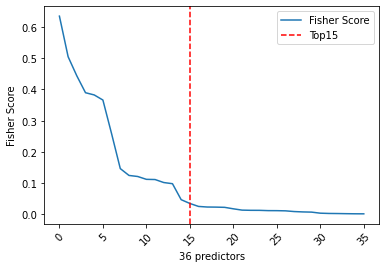

Wall time: 217 ms


In [202]:
%%time
# Visualize the Fisher Score
plt.plot(fs_df['fisherscore'].values.squeeze())
plt.axvline(x=15, linestyle='dashed', color='red')
plt.xticks(rotation=45)
plt.xlabel(str(fs_df.shape[0]) + ' predictors')
plt.ylabel('Fisher Score')
plt.legend(['Fisher Score', 'Top15'])
plt.show()

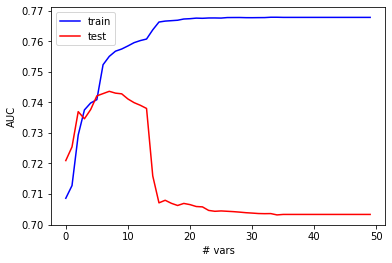

Wall time: 28.9 s


In [203]:
%%time
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, GridSearchCV

# Check how AUC change when add more variables: Top n vars
fs_scores = []
top_n_vars = 50
for i in range(1, top_n_vars+1):
    if i % 100 == 0: print('Added # top vars :', i)
    top_n_predictors = fs_df['predictor'][:i]
    clf = LogisticRegression()
    fs_scores.append(cross_validate(clf, train[top_n_predictors], train[target_var].values.squeeze(),
                                    scoring='roc_auc', cv=5, verbose=0, n_jobs=-1, return_train_score=True))

# How the AUC curve looks like when adding top vars
plt.plot([s['train_score'].mean() for s in fs_scores], color='blue')
plt.plot([s['test_score'].mean() for s in fs_scores], color='red')
plt.xlabel('# vars')
plt.ylabel('AUC')
plt.legend(['train', 'test'])
plt.show()

In [205]:
%%time
# Select the top variables based on Fisher Score
n_top_fs_vars = 50  # Top FS vars
top_fs_vars = fs_df['predictor'].values[:n_top_fs_vars]
print("Selected # vars :", len(top_fs_vars))
top_fs_vars

Selected # vars : 36
Wall time: 0 ns


array(['PAY_0_woe', 'PAY_2_woe', 'PAY_3_woe', 'PAY_5_woe', 'PAY_4_woe',
       'PAY_6_woe', 'LIMIT_BAL', 'PAY_AMT1', 'PAY_AMT4', 'PAY_AMT2',
       'EDUCATION_woe', 'PAY_AMT5', 'PAY_AMT6', 'PAY_AMT3',
       'MARRIAGE_woe', 'BILL_AMT1', 'PAY_AMT3_na', 'BILL_AMT3',
       'BILL_AMT2', 'BILL_AMT3_na', 'BILL_AMT4', 'BILL_AMT5',
       'BILL_AMT4_na', 'AGE', 'BILL_AMT6', 'PAY_AMT4_na', 'AGE_na',
       'BILL_AMT1_na', 'PAY_AMT2_na', 'BILL_AMT5_na', 'BILL_AMT6_na',
       'BILL_AMT2_na', 'PAY_AMT1_na', 'PAY_AMT6_na', 'LIMIT_BAL_na',
       'PAY_AMT5_na'], dtype=object)

#### (b) Dimensional Reduction: PCA

In [206]:
%%time
# Build PCA and check the explained variance
# Note: If the num vars were scaled (but the dummy were not) PVE is no longer correct
pca = PCA(n_components=len(predictors))
pca.fit(train[predictors])
print("PVE =", pca.explained_variance_ratio_.sum())
# Transform train, test
train_pca = pca.transform(train[predictors])
test_pca = pca.transform(test[predictors])

PVE = 1.0
Wall time: 171 ms


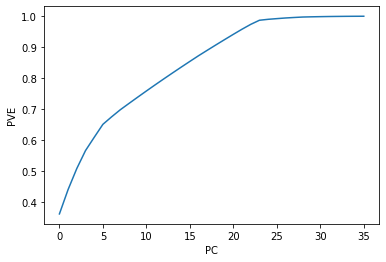

Wall time: 133 ms


In [207]:
%%time
# Visualize the PVE of PCA
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('PC')
plt.ylabel('PVE')
plt.show()

In [208]:
%%time
# Reconstruct the loading vectors
loading_vecs = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_vecs = pd.DataFrame(loading_vecs,
                            columns=['PC' + str(i) for i in list(range(1, pca.n_components_+1))],
                            index=predictors)
loading_vecs.iloc[:, :2]

Wall time: 1.01 ms


PC1       PC2
LIMIT_BAL     -0.030441 -0.022393
AGE           -0.002388 -0.033126
BILL_AMT1     -0.002581  0.000836
BILL_AMT2     -0.001682  0.001466
BILL_AMT3     -0.000630  0.000938
BILL_AMT4     -0.000007  0.002192
BILL_AMT5      0.000733  0.002525
BILL_AMT6      0.000626  0.002080
PAY_AMT1      -0.002974  0.000240
PAY_AMT2      -0.001006 -0.000533
PAY_AMT3      -0.001455 -0.000486
PAY_AMT4      -0.002180 -0.001159
PAY_AMT5      -0.002952 -0.001898
PAY_AMT6      -0.002169 -0.001211
EDUCATION_woe  0.007465  0.002652
MARRIAGE_woe   0.001178 -0.019906
PAY_0_woe      0.223674 -0.105717
PAY_2_woe      0.287744 -0.045613
PAY_3_woe      0.183421  0.094134
PAY_4_woe      0.013424  0.008395
PAY_5_woe      0.109337  0.096622
PAY_6_woe      0.093119  0.086565
LIMIT_BAL_na   0.000572 -0.000437
AGE_na         0.000467  0.000515
BILL_AMT1_na  -0.000789 -0.000493
BILL_AMT2_na   0.000194 -0.000956
BILL_AMT3_na   0.000356  0.000862
BILL_AMT4_na   0.000412  0.002329
BILL_AMT5_na  -0.000471 -0.000908
BILL_AMT6_na  -0.000077 -0.000070
PAY_AMT1_na   -0.000307  0.000415
PAY_AMT2_na    0.000618  0.000779
PAY_AMT3_na   -0.000467  0.000330
PAY_AMT4_na    0.000759 -0.000206
PAY_AMT5_na    0.002516 -0.000763
PAY_AMT6_na   -0.001190 -0.000467

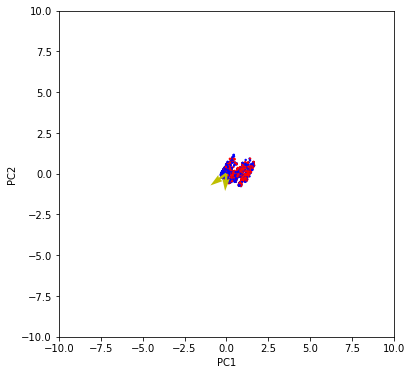

Wall time: 516 ms


In [209]:
%%time
# Visualize the group of data
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
colors = np.array(['blue'] * len(train[target_var]))
colors[train[target_var].squeeze() == 1] = 'red'
plt.scatter(x=train_pca[:, 0], y=train_pca[:, 1], color=colors, s=2)
plt.quiver([0, 0], [0, 0],
           loading_vecs.iloc[:2, :2]['PC1'].tolist(),
           loading_vecs.iloc[:2, :2]['PC2'].tolist(),
           color=['y','y'])
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## 3. Modeling

<u>Note:</u>
- Mass feature engineering may lead to overfitting. Especially with the techniques that link information from the target variable to the predictors (including Fisher Score for variable selection).
- Therefore, the k-fold cross-validation in below is convenient to use, but is not a 100% correct method to estimate the performance of the models. Train, validation and test set should be processed separately to avoid information leakage.

<u>Reference:</u>  

- Lessmann, S., Baesens, B., Seow, H. V., & Thomas, L. C. (2015). Benchmarking state-of-the-art classification algorithms for credit scoring: An update of research. European Journal of Operational Research, 247(1), 124-136.File 

In [210]:
%%time
# List of parameter tuning using cross validation for all models
model_grid = {}

Wall time: 0 ns


In [211]:
%%time
#########################################################
# MODIFY THE BELOW VALUE TO SET THE TARGET VARIABLE #
#########################################################

# Prepare the data according to the selected set of variables
var_set = 'fs'  # all = all vars, fs = top fisher score, pca = first PCs
if var_set == 'all':
    X = train[predictors]
    X_test = test[predictors]
    test_id = test[id_var]
elif var_set == 'fs':
    X = train[top_fs_vars]
    X_test = test[top_fs_vars]
    test_id = test[id_var]
elif var_set == 'pca':
    X = train_pca
    X_test = test_pca
    test_id = test[id_var]
y = train[target_var].values.squeeze()
print(X.shape)

# Update output file name
fname = '_' + data_prep + '_' + var_set + str(X.shape[1]) + '_' + exp_version
print(fname)

# Remove unused data
# del train, test, train_pca, test_pca

(20000, 36)
_full_fs36_v5.3
Wall time: 18 ms


In [212]:
fname

'_full_fs36_v5.3'

In [213]:
train.head()

cust_id  LIMIT_BAL       AGE  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  \
0    18895   0.060606  0.240741   0.194278   0.088190   0.049533   0.184214   
1     9991   0.050505  0.555556   0.196774   0.120747   0.070005   0.178235   
2    29394   0.121212  0.111111   0.260802   0.166371   0.098051   0.262266   
3    18888   0.020202  0.055556   0.170655   0.091784   0.051104   0.200689   
4    14536   0.070707  0.129630   0.208633   0.134467   0.076079   0.227005   

   BILL_AMT5  BILL_AMT6  PAY_AMT1  ...  BILL_AMT4_na  BILL_AMT5_na  \
0   0.106562   0.281509  0.003366  ...             0             0   
1   0.099718   0.275747  0.004638  ...             0             0   
2   0.195311   0.351627  0.010495  ...             0             0   
3   0.109097   0.283823  0.003960  ...             1             0   
4   0.152481   0.314530  0.006931  ...             0             0   

   BILL_AMT6_na  PAY_AMT1_na  PAY_AMT2_na  PAY_AMT3_na  PAY_AMT4_na  \
0             0            0            0            0            0   
1             0            0            0            0            0   
2             0            0            0            0            0   
3             0            0            0            0            0   
4             0            0            0            0            0   

   PAY_AMT5_na  PAY_AMT6_na  default.payment.next.month  
0            0            0                           0  
1            0            0                           0  
2            0            0                           0  
3            0            0                           1  
4            0            0                           0  

[5 rows x 38 columns]

In [214]:
train.columns

Index(['cust_id', 'LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'EDUCATION_woe',
       'MARRIAGE_woe', 'PAY_0_woe', 'PAY_2_woe', 'PAY_3_woe', 'PAY_4_woe',
       'PAY_5_woe', 'PAY_6_woe', 'LIMIT_BAL_na', 'AGE_na', 'BILL_AMT1_na',
       'BILL_AMT2_na', 'BILL_AMT3_na', 'BILL_AMT4_na', 'BILL_AMT5_na',
       'BILL_AMT6_na', 'PAY_AMT1_na', 'PAY_AMT2_na', 'PAY_AMT3_na',
       'PAY_AMT4_na', 'PAY_AMT5_na', 'PAY_AMT6_na',
       'default.payment.next.month'],
      dtype='object')

### 3.1. Modeling

In [215]:
#All features
traincv, valid = train_test_split(train, test_size=0.2, random_state=42)

In [216]:
#Fisher features
traincv, valid,ytraincv,yvalid = train_test_split(X,y, test_size=0.2, random_state=42)

In [217]:
#PCA features
traincv, valid = train_test_split(X, test_size=0.2, random_state=42)

## Logistic regression

In [219]:
# Grid search cross validation

grid={"penalty":["l1","l2"],'solver' : ['liblinear']}# l1 lasso l2 ridge
grid={"penalty":["15","16","elasticnet","none"],'solver' : ['saga']}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=5)
logreg_cv.fit(traincv,ytraincv)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWa

tuned hpyerparameters :(best parameters)  {'penalty': 'none', 'solver': 'saga'}
accuracy : 0.8166249999999999


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [220]:
import sklearn.metrics as metrics

In [221]:
#Performance
acc_lr = logreg_cv.score(valid, yvalid)
print("Accuracy: ",acc_lr)

lr_pred_proba = logreg_cv.predict_proba(valid)[:,1]

#calculate AUC of model
auc_lr = metrics.roc_auc_score(yvalid, lr_pred_proba)

#print AUC score
print("AUC: ",auc_lr)

Accuracy:  0.81925
AUC:  0.7613247117858072


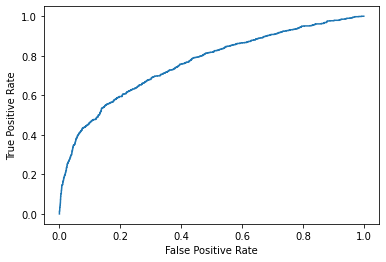

In [222]:
fpr, tpr, _ = metrics.roc_curve(yvalid, lr_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Random Forest

In [223]:
predictors = [v for v in train.columns if v not in id_var + target_var]
rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [100, 200,300, 500],
    'max_features': ['log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(traincv,ytraincv)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8], 'max_features': ['log2'],
                         'n_estimators': [100, 200, 300, 500]})

In [231]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'log2',
 'n_estimators': 300}

In [232]:
#Performance
acc_rf = CV_rfc.score(valid, yvalid)
print("Accuracy: ",acc_rf)

rf_pred_proba = CV_rfc.predict_proba(valid)[:,1]

#calculate AUC of model
auc_rf = metrics.roc_auc_score(yvalid, rf_pred_proba)

#print AUC score
print("AUC: ",auc_rf)

Accuracy:  0.81475
AUC:  0.7732172493647387


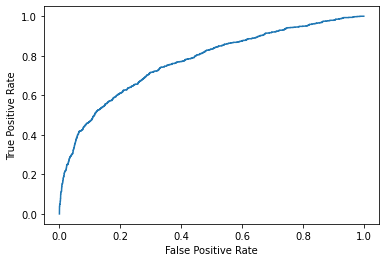

In [233]:
fpr, tpr, _ = metrics.roc_curve(yvalid, rf_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [234]:
#rfc1=RandomForestClassifier(random_state=42, max_features='log2', n_estimators= 100, max_depth=8, criterion='gini')

## KNN 

In [ ]:
#Model
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
param_grid = { 
    'n_neighbors': [3,5,7,10,11,13],
     'weights' : ['uniform', 'distance'] ,
    'leaf_size' : [10,30,50,100],
    'p' :[1,2]
}
CV_knn = GridSearchCV(estimator=knn, param_grid=param_grid, cv= 5)
CV_knn.fit(traincv, ytraincv)

print("tuned hpyerparameters :(best parameters) ",CV_knn.best_params_)
print("accuracy :",CV_knn.best_score_)

In [ ]:
#Performance
acc_knn = CV_knn.score(valid,yvalid)
print("Accuracy: ",acc_knn)

knn_pred_proba = CV_knn.predict_proba(valid)[:,1]

#calculate AUC of model
auc_knn = metrics.roc_auc_score(yvalid, knn_pred_proba)

#print AUC score
print("AUC: ",auc_knn)

Accuracy:  0.8105
AUC:  0.7378206789559806


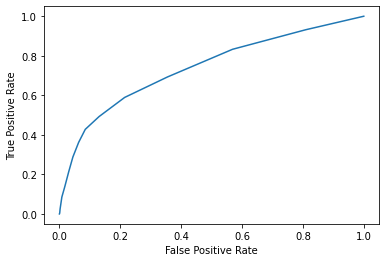

In [ ]:
fpr, tpr, _ = metrics.roc_curve(yvalid, knn_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## adaboost

In [237]:
gb = GradientBoostingClassifier()
gb.fit(traincv, ytraincv)
grid={
      "random_state":[42]}

GB_cv=GridSearchCV(gb,grid,cv=5)
GB_cv.fit(traincv, ytraincv)
print("tuned hpyerparameters :(best parameters) ",GB_cv.best_params_)
print("accuracy :",GB_cv.best_score_)


tuned hpyerparameters :(best parameters)  {'random_state': 42}
accuracy : 0.8169374999999999


In [249]:
acc_gb = GB_cv.score(valid,yvalid)
print("Accuracy: ",acc_knn)

gb_pred_proba = GB_cv.predict_proba(valid)[:,1]

#calculate AUC of model
auc_gb = metrics.roc_auc_score(yvalid, gb_pred_proba)

#print AUC score
print("AUC: ",auc_gb)

Accuracy:  0.8105
AUC:  0.7724838418887211


## XGBoosting

In [145]:
from xgboost import XGBClassifier
grid={"objective": ['binary:logistic'],'eta': [0.01,0.015,0.02,0.025,0.03,0.035,0.04,0.045,0.5],
      "max_depth":[1,2,3] , "subsample" : [0.7,0.8], "silent":["True","False"],
      "colsample_bylevel" :[0.7,0.8,0.9],"colsample_bytree":[0.7,0.8,0.9], "eval_metric":['auc'],
      "random_state":[42]}

XGB = XGBClassifier(use_label_encoder=False)
XGB_cv=GridSearchCV(XGB,grid,cv=10)

XGB_cv.fit(traincv, ytraincv)

print("tuned hpyerparameters :(best parameters) ",XGB_cv.best_params_)
print("accuracy :",XGB_cv.best_score_)

[17:15:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:15:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:15:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false

In [146]:
print("tuned hpyerparameters :(best parameters) ",XGB_cv.best_params_)

tuned hpyerparameters :(best parameters)  {'colsample_bylevel': 0.7, 'colsample_bytree': 0.8, 'eta': 0.03, 'eval_metric': 'auc', 'max_depth': 3, 'objective': 'binary:logistic', 'random_state': 42, 'silent': 'True', 'subsample': 0.8}


In [147]:
#Performance

acc_xgb = XGB_cv.score(valid, yvalid)
print("Accuracy: ",acc_xgb)
XGB_pred_proba = XGB_cv.predict_proba(valid)[:,1]

#calculate AUC of model
auc_XGB = metrics.roc_auc_score(yvalid, XGB_pred_proba)
#print AUC score
print("AUC: ",auc_XGB)

Accuracy:  0.82425
AUC:  0.7711059689964019


### 3.2. Stacking & Voting ensemble

<u>Reference:</u>
- Ensemble methods. Link: https://scikit-learn.org/stable/modules/ensemble

In [224]:
clf1 = LogisticRegression(penalty= 'l1', solver= 'liblinear')
clf2 = RandomForestClassifier(criterion = 'entropy', max_depth= 8,max_features= 'log2',n_estimators= 500, random_state= 42) 
clf3 = XGBClassifier(colsample_bylevel = 0.7, eta = 0.03, eval_metric = 'auc', max_depth = 3, objective= 'binary:logistic', random_state= 42, subsample= 0.8)
clf4 = KNeighborsClassifier(leaf_size= 10, n_neighbors= 13, p= 1, weights= 'uniform')
eclf = VotingClassifier(
     estimators=[('lr', clf1), ('rf', clf2), ('xgb', clf3), ('knn',clf4)],
     voting='soft',
     weights=[1,2,2,1]
 )

params = {'lr__C': [1.0, 100.0], 'rf__n_estimators': [20, 200], 'xgb__n_estimators': [20, 200] }
grid = GridSearchCV(estimator=eclf, param_grid=params, cv=5)
grid = grid.fit(traincv, ytraincv)

print("tuned hpyerparameters :(best parameters) ",grid.best_params_)
print("accuracy :",grid.best_score_)

C:\tools\Anaconda3\envs\py\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\envs\py\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\envs\py\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The u

tuned hpyerparameters :(best parameters)  {'lr__C': 1.0, 'rf__n_estimators': 200, 'xgb__n_estimators': 200}
accuracy : 0.817375


In [225]:
#Performance
acc_vot = grid.score(valid, yvalid)
print("Accuracy: ",acc_vot)

vot_pred_proba = grid.predict_proba(valid)[:,1]

#calculate AUC of model
auc_vot = metrics.roc_auc_score(yvalid, vot_pred_proba)

#print AUC score
print("AUC: ",auc_vot)

Accuracy:  0.8215
AUC:  0.7749313888557787


### 3.3. Debugging

To detect overfitting, underfitting problem, we can analyze the following analyses:
- Each fold of the k-fold CV
- Learning curve

In [238]:
a = pd.Series(GB_cv.predict_proba(X_test)[:,1])

In [239]:
a

0       0.394042
1       0.468546
2       0.492163
3       0.451090
4       0.496001
          ...   
9995    0.792620
9996    0.814814
9997    0.848358
9998    0.750550
9999    0.758636
Length: 10000, dtype: float64

In [242]:
target_var

['default.payment.next.month']

## 4. Make prediction

Use the best model to make prediction on test set. Submit the result to Kaggle.

In [247]:
#Prediction in test set
test['default.payment.next.month'] = pd.Series(GB_cv.predict_proba(X_test)[:,1])
submission_voting = test[['cust_id','default.payment.next.month']]
submission_voting.head()

cust_id  default.payment.next.month
0    18847                    0.394042
1     1446                    0.468546
2    14598                    0.492163
3     4209                    0.451090
4    11883                    0.496001

In [246]:
submission_voting.to_csv("submission_vote_v4.csv", index=False)

## 5. Other useful references

1. Dynamic Classifier Selection Ensembles in Python. Link: https://machinelearningmastery.com/dynamic-classifier-selection-in-python/
2. How to Develop a Feature Selection Subspace Ensemble in Python. Link: https://machinelearningmastery.com/feature-selection-subspace-ensemble-in-python/
3. How to Choose a Feature Selection Method For Machine Learning. Link: https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/